# Script to create ImageFolder format for tooth sample data

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

also: augment data to get balanced classes

structure

torch_imagefolder/mpi/m,p,i

torch_imagefolder/upperlower/upper,lower

-> no predetermined train and test sets to not fit to particular train/test split


In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy.random as npr
from sklearn.model_selection import train_test_split
import shutil

In [4]:
# constants / hyperparameters
TRAIN_TEST_SPLIT_RANDOM_SEED = 10

In [5]:
# script parameters
data_versions = [3,4,5]
data_versions.extend(range(8,22))
image_path = '/home/riikoro/fossil_data/tooth_samples'

0. Create labels.txt where they are missing
1. Get all images with labels
2. Create directory torch_imagefolder, subfolders upperlower and MPI with subdirectories for all classes
2. MPI: check balances -> augment so that balances equal
3. Divide into M P and I
5. Save images to MPI folders
6. Upper and lower: check balances, augment if necessary
7. Divide into upper lower
8. Save images to upper lower folders

In [6]:
# 1. Get all labels
def clean_azure_labels(data_version):
    tooth_labels = pd.read_csv(f'{image_path}/v{data_version}/labels_full.csv')
    tooth_labels['filename'] = image_path + '/v' + str(data_version) + '/' +  tooth_labels['filename']
    tooth_labels['tooth_index'] = tooth_labels['tooth_index'].astype('Int64') # pandas automatically converts to int due to nones present
    # undecipherable u should be none
    tooth_labels['u'] = tooth_labels['u'].apply(lambda upper: upper if upper in [0,1] else None)
    tooth_labels['u'] = tooth_labels['u'].astype('Int64') # pandas automatically converts to int due to nones present
    return tooth_labels

label_dfs = []
for data_v in data_versions:
    label_dfs.append(clean_azure_labels(data_v))

tooth_labels = pd.concat(label_dfs, axis=0)
tooth_labels.reset_index(drop=True, inplace=True)
tooth_labels

,filename,azure_output,u,MPI,tooth_index
0,/home/riikoro/fossil_data/tooth_samples/v3/0.png,M3,1,M,3
1,/home/riikoro/fossil_data/tooth_samples/v3/1.png,H1,0,M,1
2,/home/riikoro/fossil_data/tooth_samples/v3/2.png,T2,0,I,2
3,/home/riikoro/fossil_data/tooth_samples/v3/3.png,M3,0,M,3
4,/home/riikoro/fossil_data/tooth_samples/v3/4.png,p4,1,P,4
...,...,...,...,...,...
1327,/home/riikoro/fossil_data/tooth_samples/v21/17...,M3,1,M,3
1328,/home/riikoro/fossil_data/tooth_samples/v21/17...,P1,0,P,1
1329,/home/riikoro/fossil_data/tooth_samples/v21/17...,M2,0,M,2
1330,/home/riikoro/fossil_data/tooth_samples/v21/17...,M3,0,M,3


In [7]:
# try creating new directory with torch_imagefolder_i name until a nonreserved directory name is found (to not overwrite previous data versions)
# follow the structure from https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
tasks = {
    'MPI': ['M', 'P', 'I'],
    'upperlower': ['up', 'low'],
    '123': ['1', '2', '3'],
    '1234': ['1', '2', '3', '4']
}
sets = ['train', 'val', 'test']

# i = 0
# while(1):
#     try:
#         torch_imagefolder_path = f'{image_path}/torch_imagefolder_{i}'
#         os.mkdir(torch_imagefolder_path)
#         for task, classes in tasks.items():
#             task_directory = f'{torch_imagefolder_path}/{task}' 
#             os.mkdir(task_directory)
            
#             # placeholder class directories used for balancing
#             for classs in classes:
#                 os.mkdir(f'{task_directory}/{classs}')
            
#             for dataset in sets:
#                 dataset_directory = f'{task_directory}/{dataset}'
#                 os.mkdir(dataset_directory)
#                 for classs in classes:
#                     os.mkdir(f'{dataset_directory}/{classs}')
#         break
#     except FileExistsError:
#         i += 1
#         continue
torch_imagefolder_path = f'{image_path}/torch_imagefolder_0'
torch_imagefolder_path

'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0'

### Save M, P, I, upper lower to new folders

In [ ]:
# save all images first to directory above train val and test

# colname that specifies which class each row belongs to
task_column = {
    'MPI': 'MPI',
    'upperlower': 'u',
    '123': 'tooth_index',
    '1234': 'tooth_index'
}

img_i = 0 # running index to use as image filename
for task, column in task_column.items():
    for i, sample in tooth_labels.iterrows():
        value = sample[column]
        if pd.isnull(value):
            continue

        if column == 'u' and value == -1:
            continue

        # skip indices of other teeth
        if column == 'tooth_index' and task[0] != sample['MPI']:
            continue

        if column == 'u':
            if value == 1:
                value = 'up'
            elif value == 0:
                value = 'low'
            else:
                continue

        if column == 'MPI' and value == 'C':
            continue

        image = cv2.imread(sample['filename'])
        cv2.imwrite(f'{torch_imagefolder_path}/{task}/{value}/{img_i}.png', image)
        img_i += 1

## Create balanced dataset

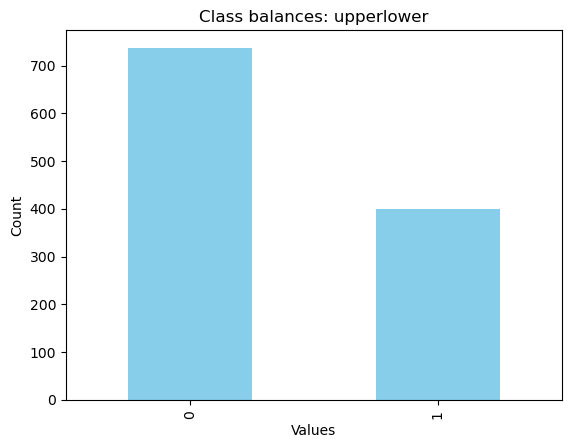

In [ ]:
# up/low
task_to_balance = 'upperlower'
column = task_column[task_to_balance]
value_counts = tooth_labels[column].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title(f'Class balances: {task_to_balance}')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

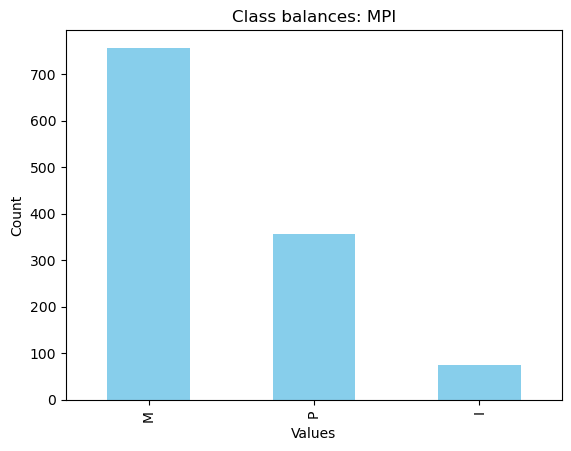

In [11]:
# MPI
task_to_balance = 'MPI'
column = task_column[task_to_balance]
value_counts = tooth_labels[column].value_counts()
value_counts.drop('C', inplace=True)

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title(f'Class balances: {task_to_balance}')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

In [75]:
# move images for 123 & 1234
classes = list(range(1,5))
task = '1234'
base_dirs = ['M123', 'P1234', 'I123']
for base_dir in base_dirs:
    for classname in classes:
        source_dir = f'{torch_imagefolder_path}/{base_dir}/{classname}'
        dest_dir = f'{torch_imagefolder_path}/{task}/{classname}'
        images = glob.glob1(source_dir, '*.png')
        for image in images:
            img_src = f'{source_dir}/{image}'
            img_dst = f'{dest_dir}/{image}'
            shutil.copy(img_src, dest_dir)

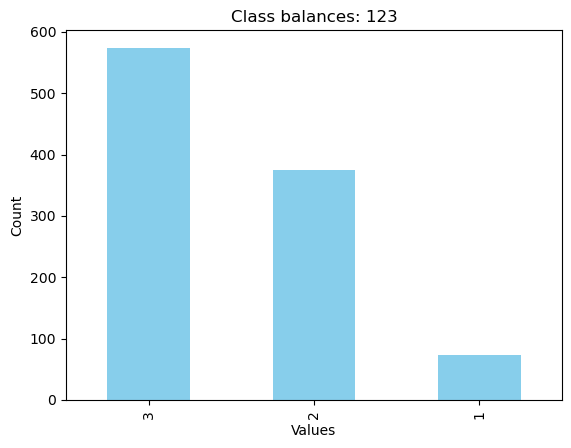

tooth_index
3    574
2    374
1     73
Name: count, dtype: Int64

In [ ]:
# 123
task_to_balance = '123'
column = task_column[task_to_balance]
value_counts = tooth_labels[column].value_counts()
value_counts.drop(4, inplace=True)

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title(f'Class balances: {task_to_balance}')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()
value_counts

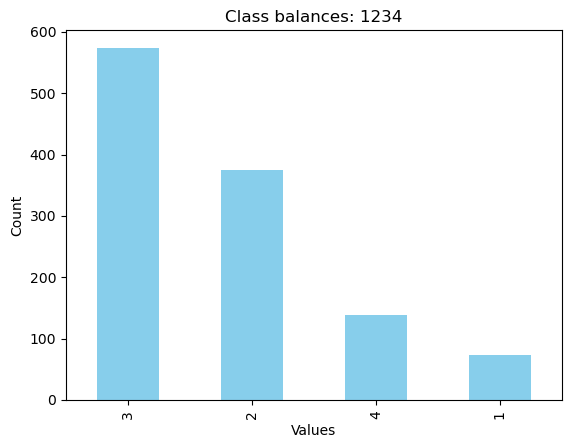

tooth_index
3    574
2    374
4    138
1     73
Name: count, dtype: Int64

In [71]:
# 1234
task_to_balance = '1234'
column = task_column[task_to_balance]
value_counts = tooth_labels[column].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title(f'Class balances: {task_to_balance}')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()
value_counts

### Create new dataset with class-balancing images

In [73]:
random_number_generator = npr.default_rng()
augmented_image_store = f'{torch_imagefolder_path}/{task_to_balance}'

augmentation_transform = transforms.Compose([
    transforms.RandomAffine(degrees=[-5,5], fill=255),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
])

def balance_column(colname, augmented_image_store):
    options = list(value_counts.index)
    to_augment = value_counts.max() - value_counts

    image_i = 0
    for classname, count_needed in to_augment.items():

        samples_of_class = tooth_labels.loc[tooth_labels[colname] == classname]
        
        # directories are called up, low not 1, 0
        if task_to_balance == 'upperlower':
            classname = 'up' if classname == 1 else 'low'

        for i in range(count_needed):
            # take random image from data that is of given class
            random_image = npr.choice(samples_of_class.index)
            image_label = tooth_labels.loc[random_image]
            image = Image.open(image_label['filename'])
            aug_image = augmentation_transform(image)
            aug_image.save(f'{augmented_image_store}/{classname}/{image_i}_aug.png')
            image_i += 1
        print(f'Added {image_i} images for class {classname}')

balance_column(column, augmented_image_store)

Added 0 images for class 3
Added 200 images for class 2
Added 636 images for class 4
Added 1137 images for class 1


## Train, val, test split

In [ ]:
# upper lower split

# get filenames in image folder to complete train test split
# u need to get paths for all classes eg upperlower/up/x.png, upperlower/low/y.png
classes = ['up', 'low']
image_stores = [f'{augmented_image_store}/{classs}' for classs in classes]
samples_per_class = value_counts.max()

image_paths = []
for i, image_store in enumerate(image_stores):
    images = glob.glob1(image_store, "*.png")
    image_paths.extend([f'{classes[i]}/{filename}' for filename in images])

# val granularity .5%, test granularity 1% -> split 1300 200 100
train_valtest_split = 150/samples_per_class
val_test_split = 50/150
X_train, X_temp = train_test_split(image_paths, test_size=train_valtest_split, random_state=TRAIN_TEST_SPLIT_RANDOM_SEED)
X_val, X_test = train_test_split(X_temp, test_size=val_test_split, random_state=TRAIN_TEST_SPLIT_RANDOM_SEED)
print(f'Sizes of datasets for upper/lower: train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}')
print(f'Splits: train {round(len(X_train)/len(image_paths),2)}, val {round(len(X_val)/len(image_paths),2)}, test {round(len(X_test)/len(image_paths),2)}')

Sizes of datasets for upper/lower: train: 905, val: 154, test: 78
Splits: train 0.8, val 0.14, test 0.07


In [31]:
# MPI split

# get filenames in image folder to complete train test split
# get paths for all classes
classes = ['M', 'P', 'I']
image_stores = [f'{augmented_image_store}/{classs}' for classs in classes]
samples_per_class = value_counts.max()

image_paths = []
for i, image_store in enumerate(image_stores):
    images = glob.glob1(image_store, "*.png")
    image_paths.extend([f'{classes[i]}/{filename}' for filename in images])

# no need for val data since no model selection is done -> only train test split
# test granularity .5% -> split rest, 200
train_test_split_frac = 200/(samples_per_class*3)
X_train, X_test = train_test_split(image_paths, test_size=train_test_split_frac, random_state=TRAIN_TEST_SPLIT_RANDOM_SEED)
print(f'Sizes of datasets for MPI: train: {len(X_train)}, test: {len(X_test)}')
print(f'Splits: train {round(len(X_train)/len(image_paths),2)}, test {round(len(X_test)/len(image_paths),2)}')

Sizes of datasets for MPI: train: 2071, test: 200
Splits: train 0.91, test 0.09


In [59]:
# 123 split

# get filenames in image folder to complete train test split
# get paths for all classes
classes = [1,2,3]
image_stores = [f'{augmented_image_store}/{classs}' for classs in classes]
samples_per_class = value_counts.max()

image_paths = []
for i, image_store in enumerate(image_stores):
    images = glob.glob1(image_store, "*.png")
    image_paths.extend([f'{classes[i]}/{filename}' for filename in images])

# no need for val data since no model selection is done -> only train test split
# test granularity .5% -> split rest, 200
train_test_split_frac = 200/(samples_per_class*3)
X_train, X_test = train_test_split(image_paths, test_size=train_test_split_frac, random_state=TRAIN_TEST_SPLIT_RANDOM_SEED)
print(f'Sizes of datasets for 123: train: {len(X_train)}, test: {len(X_test)}')
print(f'Splits: train {round(len(X_train)/len(image_paths),2)}, test {round(len(X_test)/len(image_paths),2)}')

Sizes of datasets for 123: train: 1521, test: 200
Splits: train 0.88, test 0.12


In [76]:
# 1234 split

# get filenames in image folder to complete train test split
# get paths for all classes
classes = [1,2,3,4]
image_stores = [f'{augmented_image_store}/{classs}' for classs in classes]
samples_per_class = value_counts.max()

image_paths = []
for i, image_store in enumerate(image_stores):
    images = glob.glob1(image_store, "*.png")
    image_paths.extend([f'{classes[i]}/{filename}' for filename in images])

# no need for val data since no model selection is done -> only train test split
# test granularity .5% -> split rest, 200
train_test_split_frac = 200/(samples_per_class*3)
X_train, X_test = train_test_split(image_paths, test_size=train_test_split_frac, random_state=TRAIN_TEST_SPLIT_RANDOM_SEED)
print(f'Sizes of datasets for 123: train: {len(X_train)}, test: {len(X_test)}')
print(f'Splits: train {round(len(X_train)/len(image_paths),2)}, test {round(len(X_test)/len(image_paths),2)}')

Sizes of datasets for 123: train: 2026, test: 267
Splits: train 0.88, test 0.12


In [78]:
# save train val and test images to correct directories
image_store = augmented_image_store
datasets = {'train': X_train, 'test': X_test}
for directory, images in datasets.items():
    image_destination = f'{image_store}/{directory}'
    for image_path in images:
        dest = f'{image_destination}/{image_path}'
        src = f'{image_store}/{image_path}'
        shutil.copy(src, dest)

## Try vertical split for 1,2,3

try covering the letter by removing left half of the image

In [24]:
classes = [1,2,3]
dirs = ['train', 'test']
for directory in dirs:
    path = f'{torch_imagefolder_path}/123_horizontal_split/{directory}'
    for classs in classes:
        images = glob.glob1(f'{path}/{classs}', "*.png")
        for image in images:
            img = cv2.imread(f'{path}/{classs}/{image}')
            img = img[:,round(img.shape[1]/2):img.shape[1],:]
            cv2.imwrite(f'{path}/{classs}/{image}', img)
    
